# Сравнение операторов

Идея создания этого блокнота в том, чтобы сравнить символы операторов, которые получаются в результате применения явных формул, с тем, что можно можно получить с использованием приближённых формул.

Опцион выбран самым обычным

In [102]:
# для математических функций и поддержки быстрых вычислений
import numpy as np
# комплекснозначные аналоги функций
from numpy import log, sqrt
from numpy import exp, linspace, fft, array, arange, pi
# средство рисования
import matplotlib.pyplot as plt

In [103]:
def make_rad_fft(f_x, d):
    '''
    Вычисляет преобразование Фурье без двух "пи" в показателе экспоненты
    
    Параметры:
    
    f_x - массив значений функции, задаваемый "как есть", без особенностей хранения
    и определённый на диапазоне [-M*dx/2, M*dx/2] в M = 2**N равноудалённых точках, без последней.
    
    d = dx - желаемый шаг по переменной x
    
    Области определения:
    
    xi_space = np.linspace( -pi/dx, pi/dx, num = M, endpoint = False)
    x_space = np.linspace( -M*dx/2, M*dx/2, num = M, endpoint = False)
    '''
    dx = d
    M = len(f_x)
    
    sign_change_k = np.array([(-1)**k for k in range(0, M)])
    sign_change_l = np.array([(-1)**l for l in range(0, M)])
    #учитываем порядок хранения
    sign_change_l = fft.fftshift(sign_change_l)

    f = sign_change_k * f_x
    f_hat = dx * sign_change_l * fft.fft(f)
    
    # избегаем особенностей хранения результатов fft, нам они не нужны.
    return f_hat

def make_rad_ifft(f_hat_xi, d):
    '''
    Вычисляет обратное преобразование Фурье без двух "пи" в показателе экспоненты
    
    Параметры:
    
    f_xi - массив значений функции, задаваемый "как есть", без особенностей хранения
    и определённый на диапазоне [-pi/d, pi/d] в M = 2**N равноудалённых точках, без последней.
    
    d = dx - желаемый шаг по переменной x, после того, как ifft отработает
    
    Области определения:
    
    xi_space = np.linspace( -pi/dx, pi/dx, num = M, endpoint = False)
    x_space = np.linspace( -M*dx/2, M*dx/2, num = M, endpoint = False)

    '''
    dx = d
    M = len(f_hat_xi)

    sign_change_k = np.array([(-1)**k for k in range(0, M)])
    sign_change_l = np.array([(-1)**l for l in range(0, M)])

    f =  (1/(dx)) * sign_change_k * fft.ifft(sign_change_l * f_hat_xi)
    return f

In [104]:
import time
# для измерения времени выполнения кода.
class Profiler(object):
    def __enter__(self):
        self._startTime = time.time()
         
    def __exit__(self, type, value, traceback):
        print("Elapsed time: {:.3f} sec".format(time.time() - self._startTime))

<span style="color:red">Параметры контракта down-and-out put </span>

In [105]:
# model parameters - we are going to evaluate a barrier put
T = 1
H_original = 90.0 # limit
K_original = 100.0 # strike
r_premia = 10 # annual interest rate
r = log(r_premia/100 + 1)
V0 = 0.316227766

In [106]:
# Определим функцию выплат:
def G(y, barrier, strike):
    if (barrier <= y) and (y <= strike):
        return K_original - H_original*exp(y)
    else:
        return 0

Характеристическая экспонента процесса Б-Ш
$$\psi(\xi) = \frac{{\color{green}{\sigma}}^2}{2} \xi^2 - i{\color{green}{\gamma}}\xi$$

In [107]:
sigma = V0
gamma = r - 0.5 * sigma**2 # Black-Scholes parameter, from a no-arbitrage condition

def psi(xi):
    return (sigma**2/2) * xi * xi - 1j*gamma*xi

Подготавливаем дискретизацию, задаём шкалу по переменной, связанной с ценой, производим замены
$$ y = ln(S)$$
$$ K = ln(K), H = ln(H) $$

Укладываем $M$ точек между $L \cdot ln(1/2)$  и $ L \cdot ln(2) $

In [108]:
M = 2**12  # number of points in price grid
L = 2  # scaling coefficient
y_min = L * log(0.5)
y_max = L * log(2.0)
K = log(K_original/H_original)
H = log(H_original/H_original)
y_space = np.linspace(y_min, y_max, num = M, endpoint = False)
dy = y_space[1] - y_space[0]

original_prices_space = H_original * exp(y_space)
print('В вычислениях из пространства цен участвует', M, 'точек')
print('Диапазон охваченных цен базового актива - от', original_prices_space[0] ,'до', original_prices_space[-1])

В вычислениях из пространства цен участвует 4096 точек
Диапазон охваченных цен базового актива - от 22.5 до 359.756397901


In [109]:
N = 5  # количество шагов по времени
delta_t = T/N
print('Шаг по времени равен', delta_t)

Шаг по времени равен 0.2


Действие, которое мы хотим произвести на каждом шаге итеративной процедуры, выглядит так:
$$f_n(y) = ({\color{green}{q\Delta t}}) ^{-1} \mathcal{E}_{\color{green}{q}}^- 1_{y>ln(H)} \mathcal{E}_{\color{green}{q}}^+ f_{n+1}(y)$$

Получить хотим $f_0(y)$, там для каждого $y$ и лежит ответ. Здесь ${\color{green}{q}} = \frac{1}{\Delta t} + \color{green}{r}$

Зелёным цветом обозначены константы. Определим их.

In [110]:
q = 1.0/delta_t + r
print('q = ', q)
factor = (q*delta_t)**(-1)
print('Множитель каждого шага =', factor)

# Зададим начальные уловия
f_N = array([G(y_element, H, K) for y_element in y_space]) # = g(x) i.e. payoff func

# plt.plot(original_prices_array, f_N,  'y')
# plt.ylabel('initial conditions, payoff func')
# plt.xlabel('stock price', color = 'y')
# plt.show()

q =  5.0953101798
Множитель каждого шага = 0.981294528411


В уравнении выше есть пока не определённные функции (операторы)
$$ \mathcal{E}^\pm_q f(y) = (2\pi)^{-1} \int_{-\infty}^{+\infty} e^{iy\xi} \phi^\pm_q (\xi) \hat{f}(\xi) d\xi $$


А в них - символы $\phi_q^\pm(\xi)$

Переменная $\xi$ является переменной частот, которая возникает в случае применения преобразования Фурье. Напомним, что $\hat{f}(\xi) = \int_{-\infty}^{+\infty} e^{iy\xi}f(y) dy$

Поскольку мы будем использовать готовые функции и численные методы, конкретный вид $\xi$ и $y$ предстоит выяснить

## Фи-минус

$\phi^-_q(\xi)$ рассчитываются по приближённым формулам и будут иметь вид:

$$ \phi^-_q(\xi) = exp[-i\xi F^-(0) - \xi^2 \hat{F}^-(\xi)] $$

$$ F^-(x) = 1_{[0,+\infty)}(x)(2\pi)^{-1} \int_{-\infty + i\omega_+}^{+\infty + i\omega_+} e^{ix\eta} \frac{ln(q+\psi(\eta))}{\eta^2} d\eta$$

Для того, чтобы уйти от разреза логарифма, мы используем аналитической продолжение в полуплоскость и проведём линию интегрирования иначе, совершив замену $\upsilon := \eta -i\omega_+ $:

Тогда интеграл примет вид:
$$1_{[0,+\infty)}(x)(2\pi)^{-1} \int_{-\infty}^{+\infty} e^{ix(\upsilon+i\omega_+)} \frac{ln(q+\psi(\upsilon+i\omega_+))}{(\upsilon+i\omega_+)^2} d(\upsilon)
= 1_{[0,+\infty)}(x)e^{-x\omega_+}\frac{1}{2\pi} \int_{-\infty}^{+\infty} e^{ix(\upsilon)} \frac{ln(q+\psi(\upsilon+i\omega_+))}{(\upsilon+i\omega_+)^2} d(\upsilon) $$
$$ \hat{F}^-(\xi) = \int_{-\infty}^{+\infty} e^{-ix\xi} F^-(x) dx $$

Вычислим значение подынтегральной части сразу в виде массива: $$intfunc_-(\upsilon) = \frac{ln(q+\psi(\upsilon+i\omega_+))}{(\upsilon+i\omega_+)^2}, \upsilon \in \upsilon\_space$$

In [111]:
omega_plus = 1

def integrand_minus(upsilon_array):
    """
    принимает и возвращает массив длиной в степень двойки, исходя из логики дальнейшего использования
    """
    return np.array([log(q + psi(upsilon + 1j*omega_plus)) / (upsilon + 1j*omega_plus)**2 for upsilon in upsilon_array])

# upsilon_space = np.linspace(-15.0, 15.0, num=1000, endpoint=True)

# plt.plot(upsilon_space, integrand_minus(upsilon_space).real, 'g.')
# plt.xlabel('upsilon values', color='m')
# plt.ylabel('real component', color='g')

# plt.show()

# plt.plot(upsilon_space, integrand_minus(upsilon_space).imag, 'r.')
# plt.xlabel('upsilon values', color='m')
# plt.ylabel('imag component', color='r')

# plt.show()

Теперь реализуем кусок в виде fft:
$$F^-(\color{orange}{x}) = 1_{[0,+\infty)}(\color{orange}{x})e^{-\color{orange}{x}\omega_+}\color{orange}{\frac{1}{2\pi}\int_{-\infty}^{+\infty} e^{i\color{orange}{x}\color{magenta}{\upsilon}} intfunc_-(\color{magenta}{\upsilon}) d\color{magenta}{\upsilon}} $$

Здесь возникает проблема, связанная с реализацией fft. Умножению на $e^{ix\xi}$ соответствует в numerical recipes прямое преобразование Фурье и соответствующее DFT. У нас же в определениях - обратное. По счастью, в библиотеке numpy придерживаются нашего подхода (вот документация, которая это подтверждает https://docs.scipy.org/doc/numpy/reference/routines.fft.html). Отличие только в том, что нужно учесть масштабирующий множитель.

Тогда $\color{magenta}{\upsilon}$, в которых вычисляется наша подынтегральная функция, будет относиться к домену частот. И возьмёт на себя роль, которую берёт $\color{magenta}{\xi}$ 

На вход нужно передать массив $\color{magenta}{intfunc(\upsilon)}$

Обсудим дискретную сумму, которую мы хотим видеть при этом расчёте.

$$F^-(\color{orange}{x}) = 1_{[0,+\infty)}(\color{orange}{x})e^{-\color{orange}{x}\omega_+}\color{orange}{\frac{1}{2\pi}\int_{-\infty}^{+\infty} e^{i\color{orange}{x}\color{magenta}{\upsilon}} intfunc_-(\color{magenta}{\upsilon}) d\color{magenta}{\upsilon}}$$ 

будем представлять в точках (оставим пока запись "интеграл" просто для удобства)

$$ F^-(\color{orange}{x_k}) = 1_{[0,+\infty)}(\color{orange}{x_k})e^{-\color{orange}{x_k}\omega_+}\color{orange}{\frac{1}{2\pi}\int_{-\frac{1}{2dx_k}}^{+\frac{1}{2dx_k}} e^{i\color{orange}{x_k}\color{magenta}{\upsilon_l}} \frac{ln(q+\psi(\color{magenta}{\upsilon_l}+i\omega_+))}{(\color{magenta}{\upsilon_l}+i\omega_+)^2}) d\color{magenta}{\upsilon_l}}$$

Принимая во внимание, что общая формула для $\upsilon_l = \frac{l}{dx_k M}, l = 0, 1, ..., M-1$, оценим, можно ли ей пользоваться. Для этого нужно, чтобы $\frac{ln(q+\psi(\color{magenta}{\upsilon_{-M/2}}+i\omega_+))}{(\color{magenta}{\upsilon_{-M/2}}+i\omega_+)^2} = \frac{ln(q+\psi(\color{magenta}{\upsilon_{M/2}}+i\omega_+))}{(\color{magenta}{\upsilon_{M/2}}+i\omega_+)^2}$, то есть $\frac{ln(q+\psi(\color{magenta}{-\frac{1}{2dx_k}}+i\omega_+))}{(\color{magenta}{-\frac{1}{2dx_k}}+i\omega_+)^2} = \frac{ln(q+\psi(\color{magenta}{\frac{1}{2dx_k}}+i\omega_+))}{(\color{magenta}{\frac{1}{2dx_k}}+i\omega_+)^2}$

При условии, что значение $\frac{1}{2dx_k}$ достаточно велико, выражения слева и справа будут малы, в силу характера роста знаменателя. Значит, это предположение корректно.

Используя идею метода трапеций, легко показать, что интеграл примет вид суммы:

$$ F^-(\color{orange}{x_k}) = 1_{[0,+\infty)}(\color{orange}{x_k})e^{-\color{orange}{x_k}\omega_+}\color{orange}{\frac{1}{2\pi} d\color{magenta}{\upsilon_l}}
\sum_{k=0}^{M-1} 
e^{i\color{orange}{x_k}\color{magenta}{\upsilon_l}} 
\frac{ln(q+\psi(\color{magenta}{\upsilon_l}+i\omega_+))}{(\color{magenta}{\upsilon_l}+i\omega_+)^2})$$

Здесь $d\color{magenta}{\upsilon_l}$ понимается как расстояние (одинаковое) между соседними точками $\upsilon_l$

Подставим выражение для $\upsilon_l = \frac{l}{dx_k M}$:

$$ F^-(\color{orange}{x_k}) = 1_{[0,+\infty)}(\color{orange}{x_k})e^{-\color{orange}{x_k}\omega_+}\color{orange}{\frac{1}{2\pi} d\color{magenta}{\upsilon_l}}
\sum_{k=0}^{M-1} 
e^{i\color{orange}{x_k}\color{magenta}{\frac{l}{dx_k M}}} 
\frac{ln(q+\psi(\color{magenta}{\frac{l}{dx_k M}}+i\omega_+))}{(\color{magenta}{\frac{l}{dx_k M}}+i\omega_+)^2})$$

Исходя из соображения, что мы хотим использовать для вычисления интеграла библиотечное ifft, которое представляет из себя выражение: $ B_k := \frac{1}{M} \sum_{l=0}^{M-1} e^{2\pi i \frac{kl}{M}} f(\frac{l}{dx_k M}), k = 0, ..., M-1$, нам нужно подобрать соответствующие $x_k$

Приравнивая показатели экспонент, получим $ 2\pi i \frac{kl}{M} =  i\color{orange}{x_k}\color{magenta}{\frac{l}{dx_k M}}$, то есть $ 2\pi k =  \color{orange}{x_k}\color{magenta}{\frac{1}{dx_k}} $, следовательно $ \color{orange}{x_k} = 2\pi k \color{magenta}{dx_k}$

Подставим теперь это выражение в сумму

$$ F^-(\color{orange}{2\pi k \color{magenta}{dx_k}}) = 1_{[0,+\infty)}(\color{orange}{2\pi k \color{magenta}{dx_k}})e^{-\color{orange}{2\pi k \color{magenta}{dx_k}}\omega_+}\color{orange}{\frac{1}{2\pi} d\color{magenta}{\upsilon_l}}
\sum_{k=0}^{M-1} 
e^{i\color{orange}{2\pi k }\color{magenta}{\frac{l}{M}}} 
\frac{ln(q+\psi(\color{magenta}{\frac{l}{dx_k M}}+i\omega_+))}{(\color{magenta}{\frac{l}{dx_k M}}+i\omega_+)^2})$$

Применяя библиотечную процедуру, которой мы передадим $f(\frac{l}{dx_k M}) := \frac{ln(q+\psi(\color{magenta}{\frac{l}{dx_k M}}+i\omega_+))}{(\color{magenta}{\frac{l}{dx_k M}}+i\omega_+)^2}, l = 0, 1, ..., M-1$, получим 

$$ F^-(\color{orange}{2\pi k \color{magenta}{dx_k}}) = e^{-\color{orange}{2\pi k \color{magenta}{dx_k}}\omega_+}\color{orange}{\frac{1}{2\pi} d\color{magenta}{\upsilon_l}}
M \cdot B_k, k=0,1,..., M-1$$

In [112]:
M = 2**16

dx = 0.01

x_space = np.linspace( -M*dx/2, M*dx/2, num = M, endpoint = False)
u_space = np.linspace(-pi/dx, pi/dx, num = M, endpoint = False)
du = u_space[1] - u_space[0]

print("В вычислениях будет использовано всего", M, "точек")
print("du = ", du, "Частота меняется от ", -pi/dx, "до", pi/dx)

print("dx = ", dx, "Пространственная переменная меняется от ", x_space[0], "до", x_space[M-1])

print("Отношение длин диапазонов пространство/частота:", (x_space[M-1] -  x_space[0])/(2*pi/dx))
print("Отношение длин диапазонов частота/пространство:", (2*pi/dx)/(x_space[M-1] -  x_space[0]))


print("Омега плюс равна", omega_plus)

from numpy import pi
# чтобы понять, куда мы попали
# print("Разлёт переменной частот, частота в герцах", 1/(2*dx))
# print("Разлёт переменной частот, частота в радианах", 2*pi/(2*dx))

В вычислениях будет использовано всего 65536 точек
du =  0.00958737992431 Частота меняется от  -314.1592653589793 до 314.1592653589793
dx =  0.01 Пространственная переменная меняется от  -327.68 до 327.67
Отношение длин диапазонов пространство/частота: 1.04302191955
Отношение длин диапазонов частота/пространство: 0.958752621833
Омега плюс равна 1


### Замечание
<span style='color:red'>В подборе параметров есть особенность</span>, связанная с вычислением $ \phi^-_q(\xi) = exp[-i\xi F^-(0) - \xi^2 \hat{F}^-(\xi)] $, а именно части 

$$e^{- \xi^2 \hat{F}^-(\xi)}$$

При достаточно больших $\xi$ появление отрицательного сомножителя (значения) $\hat{F}^-(\xi)$ превращает экспоненту в огромное число, вызывающее переполнение. Поскольку в силу природы вычислений (DFT) на концах области определения $\hat{F}^-(\xi)$ может возникать осцилляция, этот эффект будет проявляться.

Решение состоит в том, чтобы задавать соизмеримые области изменения по $x$ и $\xi$. И следить за диапазонами - не "забитый" рост уже $e^{100}$ может создать проблемы, не говоря уже о тысячах

In [113]:
# plt.plot(u_space[(u_space>-10) & (u_space<10)], integrand_minus(u_space)[(u_space>-10) & (u_space<10)].real, 'g.')
# plt.show()

def F_minus_capital():
    indicator = np.where(x_space >= 0, 1, 0)
    trimmed_x_space = indicator*x_space # чтобы при "сильно отрицательных" x не росла экспонента
    integral = make_rad_ifft(integrand_minus(u_space), dx)
    exponent = exp(-trimmed_x_space * omega_plus)
    return indicator * exponent * integral 

# На самом деле, fm = F_minus_capital(). Но я вижу, что в мнимой части появляются всё же некоторые значения, 
# а их, в силу симметричности подынтегральной функции около нуля, скорее всего, в пределе нет.
# Попробую убрать, чтобы оценить влияние на ошибку. fm = F_minus_capital().real
# UPD: Оценил и не увидел изменений при M=2**18, dx = 0.001
fm = F_minus_capital()
               
# plt.plot(x_space[(u_space>-1) & (u_space<1)], fm.real[(u_space>-1) & (u_space<1)], 'g.')

# plt.plot(x_space, fm.real, 'g.')
# plt.xlabel('x_array values', color='y')
# plt.ylabel('real component', color='g')
# plt.show()

# plt.plot(x_space, fm.imag, 'r')
# plt.xlabel('x_array values', color='y')

# plt.ylabel('imag component', color='r')
# plt.show()

#Теперь нас интересует $$ \hat{F}^-(\xi) = \int_{-\infty}^{+\infty} e^{-ix\xi} F^-(x) dx $$

In [114]:
# Заметим, что входным аргументом здесь будет вовсе не кси, а x, на которых считается подынтегральная функция

# def F_minus_capital_hat():
#     return fft.fft(F_minus_capital())
F_m_hat = make_rad_fft(fm, dx)

# plt.plot(u_space, F_m_hat.real, 'g--')
# plt.xlabel('y_space values', color='y')
# plt.ylabel('real component', color='g')
# plt.show()

# plt.plot(u_space, F_m_hat.imag, 'r--')
# plt.xlabel('y_space values', color='y')
# plt.ylabel('imag component', color='r')
# plt.show()

Наконец, у нас достаточно функций, чтобы закодировать 
$$ \phi^-_q(\xi) = exp[-i\xi F^-(0) - \xi^2 \hat{F}^-(\xi)] $$

Но прежде стоит заметить, что нам удобнее, из практических соображений, вычислять $\phi^-_q(\xi)$ сразу в виде массива. Тогда нам нужно некоторым специальным образом обработать часть $ -i\xi F^-(0)$

In [115]:
def make_phi_minus_array(xi_array):
    first_term = - 1j * xi_array * (fm[M//2])
    second_term = - xi_array * xi_array * F_m_hat
    return exp(first_term + second_term)

def make_cf_bs_phi_minus_array(xi_array):
    beta_minus = - (gamma + sqrt(gamma**2 + 2*sigma**2 * q))/sigma**2
    phi_minus_array = array([-beta_minus/(-beta_minus + 1j*xi) for xi in xi_array])
    return phi_minus_array

mex_symbol_minus = make_phi_minus_array(u_space)
bs_symbol_minus = make_cf_bs_phi_minus_array(u_space)

# ax1 = plt.subplot(411)
# plt.plot(u_space, mex_symbol_minus.real, 'g.')
# plt.ylabel('real mex', color='g')
# plt.setp(ax1.get_xticklabels(), visible=False)

# ax2 = plt.subplot(412, sharex=ax1)
# plt.plot(u_space, bs_symbol_minus.real, 'g.')
# plt.ylabel('real bs', color='g')
# plt.setp(ax2.get_xticklabels(), visible=False)

# ax3 = plt.subplot(413, sharex=ax1)
# plt.plot(u_space, (mex_symbol_minus).imag, 'r.')
# plt.ylabel('imag mex', color='r')
# plt.setp(ax3.get_xticklabels(), visible=False)

# ax4 = plt.subplot(414, sharex=ax1)
# plt.plot(u_space, bs_symbol_minus.imag, 'r.')
# plt.ylabel('imag bs', color='r')

# plt.xlabel('xi_space values', color='m')

# filename_real_pic = "symbol_phi_minus_bs_mex N %2d L %.1f M %2d.png"  % (N, L, M)
# plt.savefig("out_pictures/" + filename_real_pic)
# plt.show()

# plt.show()

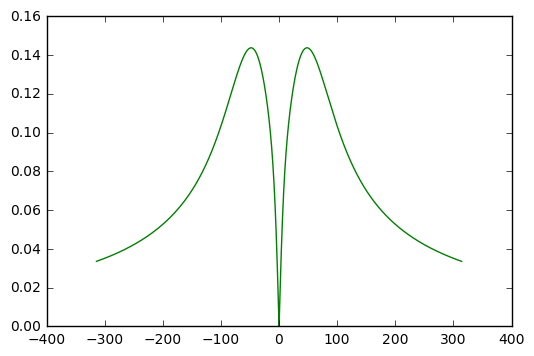

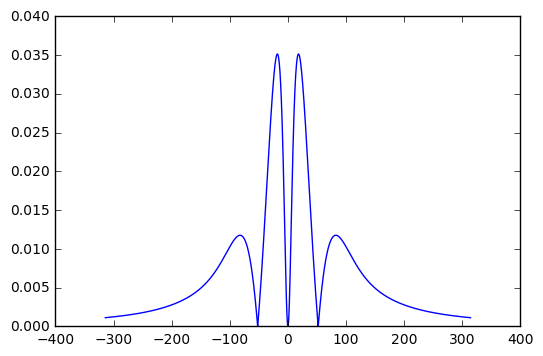

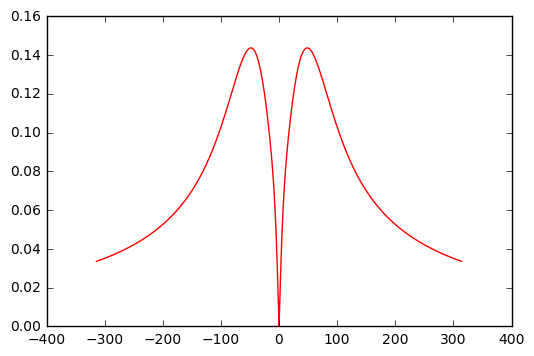

In [116]:
abs_error = abs(mex_symbol_minus - bs_symbol_minus)
plt.plot(u_space, abs_error, 'g')
plt.show()

abs_error_real = abs(mex_symbol_minus.real - bs_symbol_minus.real)
plt.plot(u_space, abs_error_real, 'b')
plt.show()

abs_error_imag = abs(mex_symbol_minus.imag - bs_symbol_minus.imag)
plt.plot(u_space, abs_error_imag, 'r')
plt.show()

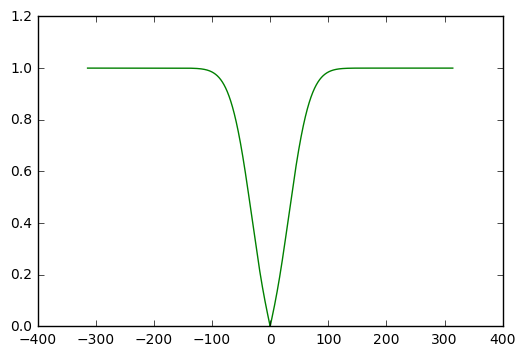

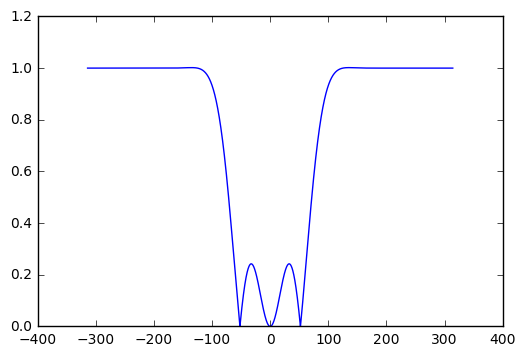

/home/basil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide


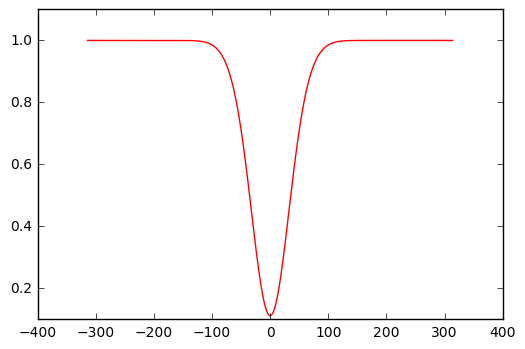

In [117]:
rel_error = abs(mex_symbol_minus - bs_symbol_minus)/abs(bs_symbol_minus)
plt.plot(u_space, rel_error, 'g')
plt.show()

rel_error_real = abs(mex_symbol_minus.real - bs_symbol_minus.real)/abs(bs_symbol_minus.real)
plt.plot(u_space, rel_error_real, 'b')
plt.show()

rel_error_imag = abs(mex_symbol_minus.imag - bs_symbol_minus.imag)/abs(bs_symbol_minus.imag)
plt.plot(u_space, rel_error_imag, 'r')
plt.show()

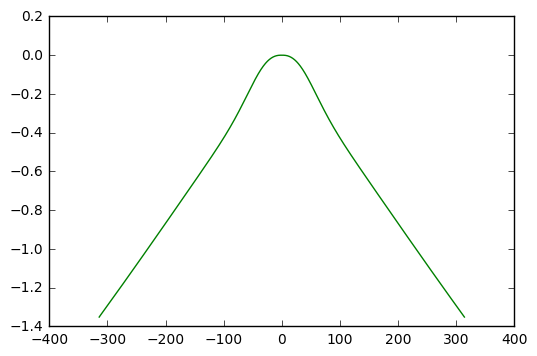

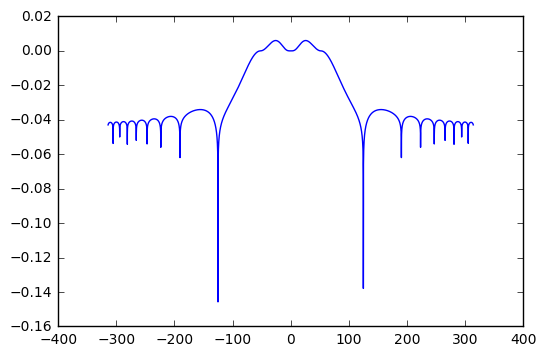

/home/basil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide


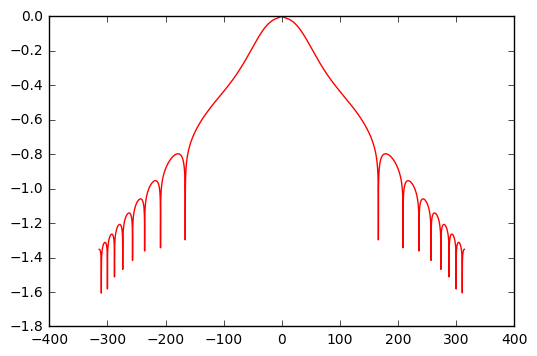

In [118]:
total_error = log(abs(mex_symbol_minus)/abs(bs_symbol_minus))*abs(mex_symbol_minus - bs_symbol_minus)
plt.plot(u_space, total_error, 'g')
plt.show()

total_error_real = log(abs(mex_symbol_minus.real)/abs(bs_symbol_minus.real))*\
  abs(mex_symbol_minus.real - bs_symbol_minus.real)
plt.plot(u_space, total_error_real, 'b')
plt.show()

total_error_imag = log(abs(mex_symbol_minus.imag)/abs(bs_symbol_minus.imag))*\
  abs(mex_symbol_minus.imag - bs_symbol_minus.imag)
plt.plot(u_space, total_error_imag, 'r')
plt.show()


## Фи-плюс

$\phi^+_q(\xi)$ будут иметь вид:

$$ \phi^+_q(\xi) = exp[i\xi F^+(0) - \xi^2 \hat{F}^+(\xi)], $$
$$ F^+(x) = 1_{(-\infty, 0]}(x)(2\pi)^{-1} \int_{-\infty + i\omega_-}^{+\infty + i\omega_-} e^{ix\eta} \frac{ln(q+\psi(\eta))}{\eta^2} d\eta = $$
$$ = 1_{(-\infty, 0]}(x)(2\pi)^{-1} \int_{-\infty}^{+\infty} e^{ix(\upsilon+i\omega_-)} \frac{ln(q+\psi(\upsilon+i\omega_-))}{(\upsilon+i\omega_-)^2} d(\upsilon) = $$ 
$$ = 1_{(-\infty, 0]}(x)e^{-x\omega_-}\frac{1}{2\pi} \int_{-\infty}^{+\infty} e^{ix(\upsilon)} \frac{ln(q+\psi(\upsilon+i\omega_-))}{(\upsilon+i\omega_-)^2} d(\upsilon);$$
$$ \hat{F}^+(\xi) = \int_{-\infty}^{+\infty} e^{-ix\xi} F^+(x) dx. $$

In [119]:
# Мы используем те же сетки, на которых считаем плюсовой фактор, поэтому здесь ничего пересчитывать не будем.
omega_minus = -1

Вычислим значение подынтегральной части сразу в виде массива: $$intfunc(\upsilon) = \frac{ln(q+\psi(\upsilon+i\omega_-))}{(\upsilon+i\omega_-)^2}, \upsilon \in \upsilon\_space$$

In [120]:
def integrand_plus(upsilon_array):
    """
    принимает и возвращает массив длиной M,
    работает (должна) на upsilon_space по умолчанию
    тоже должна возвращать
    """
    return np.array([log(q + psi(upsilon + 1j*omega_minus)) / (upsilon + 1j*omega_minus)**2 for upsilon in upsilon_array])

# plt.plot(upsilon_space, integrand_plus(upsilon_space).real, 'g.')
# plt.xlabel('upsilon values', color='m')
# plt.ylabel('real component', color='g')
# plt.show()

# plt.plot(upsilon_space, integrand_plus(upsilon_space).imag, 'r.')
# plt.xlabel('xi_space values', color='m')
# plt.ylabel('imag component', color='r')
# plt.show()

Теперь реализуем кусок в виде fft:
$$ F^+(x) = 1_{(-\infty, 0]}(x)e^{-x\omega_-}\color{magenta}{\frac{1}{2\pi} \int_{-\infty}^{+\infty} e^{ix(\upsilon)} intfunc(\upsilon) d(\upsilon)} $$

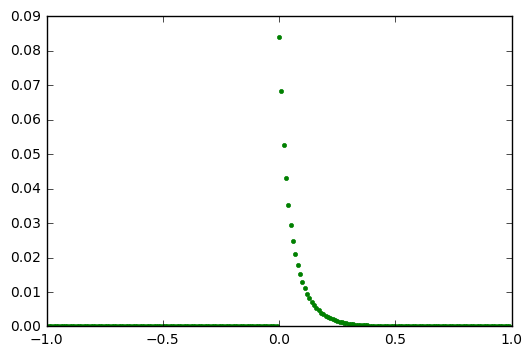

In [121]:
# factor functions
def F_plus_capital():
    indicator = np.where(x_space <= 0, 1, 0)
    trimmed_x_space = indicator*x_space # чтобы при "сильно положительных" x не росла экспонента
    integral = make_rad_ifft(integrand_plus(u_space), dx)
    exponent = exp(-trimmed_x_space * omega_minus)
    return indicator * exponent * integral 

fp = F_plus_capital()
               
plt.plot(x_space[(x_space>-1) & (x_space<1)], fm.real[(x_space>-1) & (x_space<1)], 'g.')
plt.show()
# plt.plot(x_space, fp.real, 'g.')
# plt.xlabel('x_array values', color='y')
# plt.ylabel('real component', color='g')
# plt.show()

# plt.plot(x_space, fp.imag, 'r')
# plt.xlabel('x_array values', color='y')

# plt.ylabel('imag component', color='r')
# plt.show()

Теперь нас интересует $$ \hat{F}^+(\xi) = \int_{-\infty}^{+\infty} e^{-ix\xi} F^+(x) dx $$

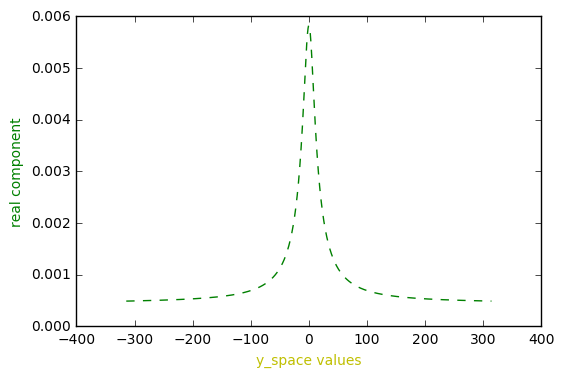

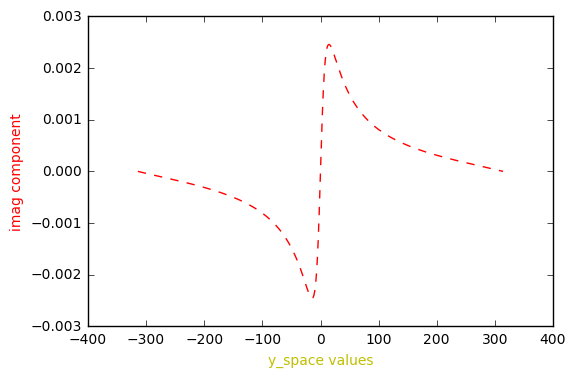

In [122]:
F_p_hat = make_rad_fft(fp, dx)

plt.plot(u_space, F_p_hat.real, 'g--')
plt.xlabel('y_space values', color='y')
plt.ylabel('real component', color='g')
plt.show()

plt.plot(u_space, F_p_hat.imag, 'r--')
plt.xlabel('y_space values', color='y')
plt.ylabel('imag component', color='r')
plt.show()



Наконец, у нас достаточно функций, чтобы закодировать 
$$ \phi^+_q(\xi) = exp[i\xi F^+(0) - \xi^2 \hat{F}^+(\xi)] $$


9.65192194485


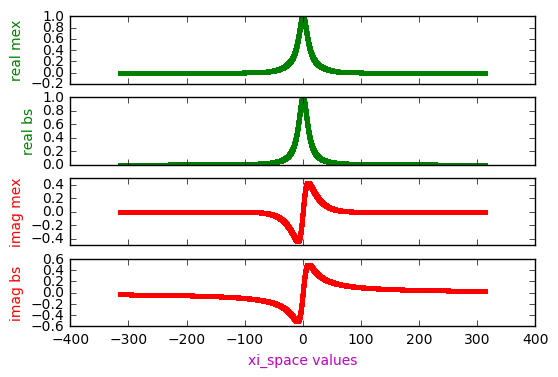

In [123]:
def make_phi_plus_array(xi_array):
    first_term = 1j *  xi_array * fp[M//2]
    second_term = - xi_array * xi_array * F_p_hat
    return exp(first_term + second_term)

def make_cf_bs_phi_plus_array(xi_array):
    beta_plus = - (gamma - sqrt(gamma**2 + 2*sigma**2 * q))/sigma**2
    print(beta_plus)
    phi_plus_array = array([beta_plus/(beta_plus - 1j*xi) for xi in xi_array])
    return phi_plus_array

mex_symbol_plus = make_phi_plus_array(u_space)
bs_symbol_plus = make_cf_bs_phi_plus_array(u_space)

ax1 = plt.subplot(411)
plt.plot(u_space, mex_symbol_plus.real, 'g.')
plt.ylabel('real mex', color='g')
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = plt.subplot(412, sharex=ax1)
plt.plot(u_space, bs_symbol_plus.real, 'g.')
plt.ylabel('real bs', color='g')
plt.setp(ax2.get_xticklabels(), visible=False)

ax3 = plt.subplot(413, sharex=ax1)
plt.plot(u_space, mex_symbol_plus.imag, 'r.')
plt.ylabel('imag mex', color='r')
plt.setp(ax3.get_xticklabels(), visible=False)

ax4 = plt.subplot(414, sharex=ax1)
plt.plot(u_space, bs_symbol_plus.imag, 'r.')
plt.ylabel('imag bs', color='r')

plt.xlabel('xi_space values', color='m')

# filename_real_pic = "symbol_phi_plus_bs_mex N %2d L %.1f M %2d.png"  % (N, L, M)
# plt.savefig("out_pictures/" + filename_real_pic)
# plt.show()

plt.show()

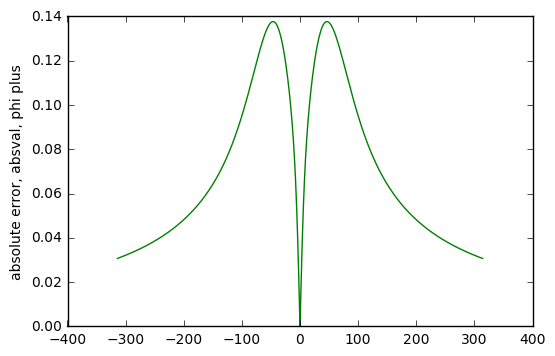

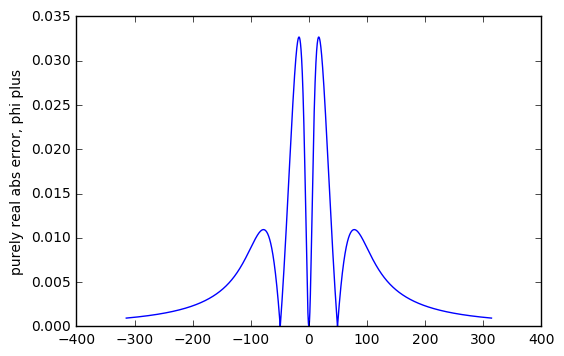

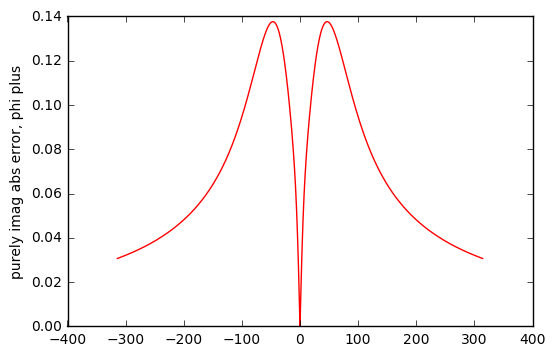

In [124]:
abs_error = abs(mex_symbol_plus - bs_symbol_plus)
plt.plot(u_space, abs_error, 'g')
plt.ylabel('absolute error, absval, phi plus')
plt.show()

abs_error_real = abs(mex_symbol_plus.real - bs_symbol_plus.real)
plt.plot(u_space, abs_error_real, 'b')
plt.ylabel('purely real abs error, phi plus')
plt.show()

abs_error_imag = abs(mex_symbol_plus.imag - bs_symbol_plus.imag)
plt.plot(u_space, abs_error_imag, 'r')
plt.ylabel('purely imag abs error, phi plus')
plt.show()